In [1]:
import wandb
from math import isnan 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wandb
from tqdm import tqdm
from cycler import cycler
import matplotlib as mpl

wandb_id = "" # YOUR WANDB ID
api = wandb.Api()
project = "FedResFinal"
runs = api.runs(f"{wandb_id}/{project}")
all_runs = []
for run in runs:
    if run.State=="finished" and "n_workers" in run.config and run.config["heterogeneity"]=="dir" and run.config["imbalance"] and "lambda/client_0" in run.summary:# and run.config["heterogeneity"]=="mix":
        config = {**run.config}
        for client in tqdm(range(config["n_workers"])):
            run_dict = {}
            for split in ["train", "test"]:
                summary = {**run.summary}
                run_dict = {**run_dict, **config, **summary, "client":client,
                            "lambda":summary[f"lambda/client_{client}"],
                                 f"{split}_loss": summary[f"loss/{split}/client_{client}"],
                                f"{split}_acc": summary[f"accuracy/{split}/client_{client}"],
                                f"slack_{split}":(summary[f"loss/{split}/client_{client}"]-summary[f"loss/{split}/mean"]-config["tolerance_epsilon"]),
                                "run": run.id}
                if f"perturbation/client_{client}" in summary:
                    run_dict["perturbation"] = summary[f"perturbation/client_{client}"]
                    run_dict[f"slack_{split}"] = run_dict[f"slack_{split}"]-summary[f"perturbation/client_{client}"]
                run_dict[f"slack_{split}"] = run_dict[f"slack_{split}"]
            #run_dict["slack_diff"] = 
            all_runs.append(run_dict)
df = pd.DataFrame(all_runs)               

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 756.78it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 798.95it/s]


/var/folders/b7/1tcskkh97qnc_cyt4nbl9lp40000gn/T/ipykernel_84060/585050324.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_df["train_loss"] = query_df["train_loss"]


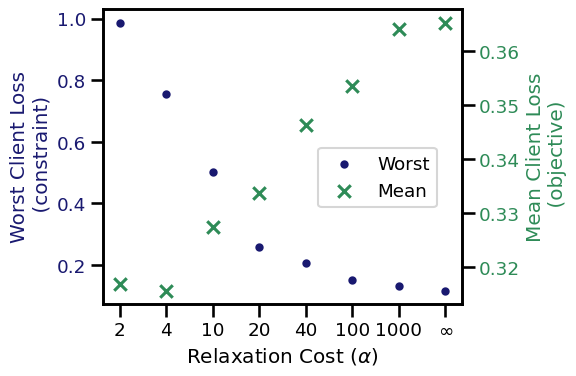

In [40]:
COLOR_Mean = "seagreen"#"#69b3a2"
COLOR_Max = "midnightblue"#"#3399e6"
df = df[df["dataset"]=="cifar10"]
mpl.rcParams['lines.linewidth'] = 1.8
sns.set_context("talk", font_scale=0.8)
query_df = df.query("perturbation_penalty>=2 and n_minority==3 and reduce_to_ratio==0.1 and tolerance_epsilon==0.02")
query_df["train_loss"] = query_df["train_loss"]
query_df.loc[query_df["formulation"]=='imbalance-fl', "perturbation_penalty"] = 10e5
query_df = query_df.sort_values("perturbation_penalty")
query_df.loc[query_df["formulation"]=='imbalance-fl', "perturbation_penalty"] = "$\infty$"
gpby = query_df.groupby("perturbation_penalty")["train_loss"]
mean_l = gpby.mean()
max_l = gpby.max()
min_l = gpby.min()
err_bar = np.stack((min_l.values,max_l.values))
x = [str(int(val)) for val in query_df["perturbation_penalty"].unique()[:-1]]
x.append(query_df["perturbation_penalty"].unique()[-1])
fig, ax1 = plt.subplots(figsize=(6, 4))
ax2 = ax1.twinx()
ax1.scatter(x, max_l.values-mean_l.values, marker=".", label="Worst", color=COLOR_Max)
ax2.scatter(x, mean_l.values, marker="x", label="Mean", color=COLOR_Mean)
ax1.tick_params(axis="y", labelcolor=COLOR_Max)
ax2.tick_params(axis="y", labelcolor=COLOR_Mean)
ax2.set_ylabel("Mean Client Loss\n (objective)", color=COLOR_Mean)
ax1.set_ylabel("Worst Client Loss\n (constraint)", color=COLOR_Max)
#plt.errorbar(x= x, y = mean_l.values, yerr=err_bar, capsize=1, ls='none')
#query_df.loc[query_df["formulation"]=='imbalance-fl', "perturbation_penalty"] = -1
#query_df = query_df[query_df["formulation"]=='imbalance-fl-res']
#sns.lmplot(data=query_df, y="train_loss", x="perturbation_penalty", markers=".")
ax1.set_xlabel("Relaxation Cost ($\\alpha$)")
fig.legend(bbox_to_anchor=(.55, .6), loc='upper left', borderaxespad=0)
fig.tight_layout()
plt.savefig("alpha_tradeoff.pdf", dpi=250)
#plt.ylabel("Client Loss (Train)")
#plt.ylim((0.86, 0.93))

In [41]:
def l2(x):
    if x.empty:
        return None 
    else: 
        x = x.dropna()
        return np.sqrt(np.mean(x))

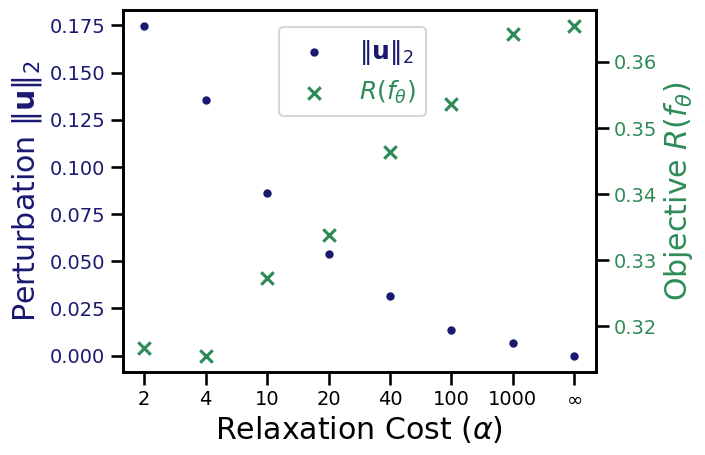

In [42]:
COLOR_Mean = "seagreen"#"#69b3a2"
COLOR_Max = "midnightblue"#"#3399e6"
df = df[df["dataset"]=="cifar10"]
mpl.rcParams['lines.linewidth'] = 1.8
sns.set_context("talk", font_scale=1.2)
query_df = df.query("n_minority==3 and reduce_to_ratio==0.1 and perturbation_penalty>=2  and tolerance_epsilon==0.02 and imbalance==True")
query_df.loc[query_df["formulation"]=='imbalance-fl', "perturbation_penalty"] = 10e5
query_df = query_df.sort_values("perturbation_penalty")
query_df.loc[query_df["formulation"]=='imbalance-fl', "perturbation_penalty"] = "$\infty$"
query_df["perturbation2"] = query_df["perturbation"]**2
gpby = query_df.groupby("perturbation_penalty")["train_loss"]
mean_l = gpby.mean()
gpby = query_df.groupby("perturbation_penalty")["perturbation2"]
max_pert = gpby.agg(l2)
coeffs = query_df["perturbation_penalty"].unique()
max_pert[-1] = 0
# convert x to string with decimal places
# only if the value is less than 1
x = []
for val in query_df["perturbation_penalty"].unique()[:-1]:
    if val < 1:
        x.append(str(val))
    else:
        x.append(str(int(val)))
x.append(query_df["perturbation_penalty"].unique()[-1])
fig, ax1 = plt.subplots(figsize=(7.5, 5))
ax2 = ax1.twinx()
ax1.scatter(x, max_pert, marker=".", label="$\|\mathbf{u} \|_2$", color=COLOR_Max)
ax2.scatter(x, mean_l.values, marker="x", label="$R(f_{\\theta})$", color=COLOR_Mean)
ax1.tick_params(axis="y", labelcolor=COLOR_Max, labelsize=14)
ax2.tick_params(axis="y", labelcolor=COLOR_Mean, labelsize=14)
ax1.tick_params(axis="x",  labelsize=14)
ax2.set_ylabel("Objective $R(f_{\\theta})$", color=COLOR_Mean)
ax1.set_ylabel("Perturbation $\|\mathbf{u} \|_2$", color=COLOR_Max)
l = fig.legend(bbox_to_anchor=(.5, .9), loc='upper center', fontsize=18, borderaxespad=0)
for text, color in zip(l.get_texts(), (COLOR_Max, COLOR_Mean)):
    text.set_color(color)
ax1.set_xlabel("Relaxation Cost ($\\alpha$)")
fig.tight_layout()
plt.savefig("alpha_perturbation_all.pdf", dpi=250,  bbox_inches='tight')